In [ ]:
import zipfile
import os
zip_file_path = '/content/archive.zip'
extraction_path = '/content/dataset'
os.makedirs(extraction_path, exist_ok=True)

# Unzip the archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"'{zip_file_path}' unzipped to '{extraction_path}' successfully.")

# Verify extraction by listing contents of the extracted directory
print("Contents of the extracted directory:")
for root, dirs, files in os.walk(extraction_path):
    level = root.replace(extraction_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')

'/content/archive.zip' unzipped to '/content/dataset' successfully.
Contents of the extracted directory:
dataset/
    seg_pred/
        seg_pred/
            20506.jpg
            9976.jpg
            20786.jpg
            15485.jpg
            11752.jpg
            5245.jpg
            11000.jpg
            2899.jpg
            17988.jpg
            9786.jpg
            18858.jpg
            19181.jpg
            4127.jpg
            15349.jpg
            4101.jpg
            2133.jpg
            23790.jpg
            19432.jpg
            24194.jpg
            19707.jpg
            21952.jpg
            2642.jpg
            22940.jpg
            14919.jpg
            21938.jpg
            15391.jpg
            14653.jpg
            4353.jpg
            9864.jpg
            6.jpg
            20302.jpg
            24302.jpg
            5361.jpg
            23863.jpg
            11488.jpg
            8158.jpg
            2844.jpg
            20442.jpg
            5430.jpg
            20

In [ ]:
import tensorflow as tf

# Define image size and batch size as specified in the subtask
image_size = (224, 224)
batch_size = 32

# Path to the extracted dataset (from the previous step)
extraction_path = '/content/dataset'
base_train_dir = os.path.join(extraction_path, 'seg_train', 'seg_train')

if not os.path.exists(base_train_dir):
    print(f"Error: Training directory not found at {base_train_dir}")
else:
    print(f"Loading images from: {base_train_dir}")
    train_ds_full = tf.keras.utils.image_dataset_from_directory(
        base_train_dir,
        labels='inferred',
        label_mode='int',
        image_size=image_size,
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=True,
        seed=42
    )

    print(f"Class names: {train_ds_full.class_names}")

    # Inspect image classes and their distribution
    class_counts = {class_name: 0 for class_name in train_ds_full.class_names}
    total_images = 0

    for images, labels in train_ds_full:
        for label in labels.numpy():
            class_counts[train_ds_full.class_names[label]] += 1
        total_images += images.shape[0]

    print(f"Total images loaded: {total_images}")
    print("Image distribution per class:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")


Loading images from: /content/dataset/seg_train/seg_train
Found 14034 files belonging to 6 classes.
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Total images loaded: 14034
Image distribution per class:
  buildings: 2191 images
  forest: 2271 images
  glacier: 2404 images
  mountain: 2512 images
  sea: 2274 images
  street: 2382 images


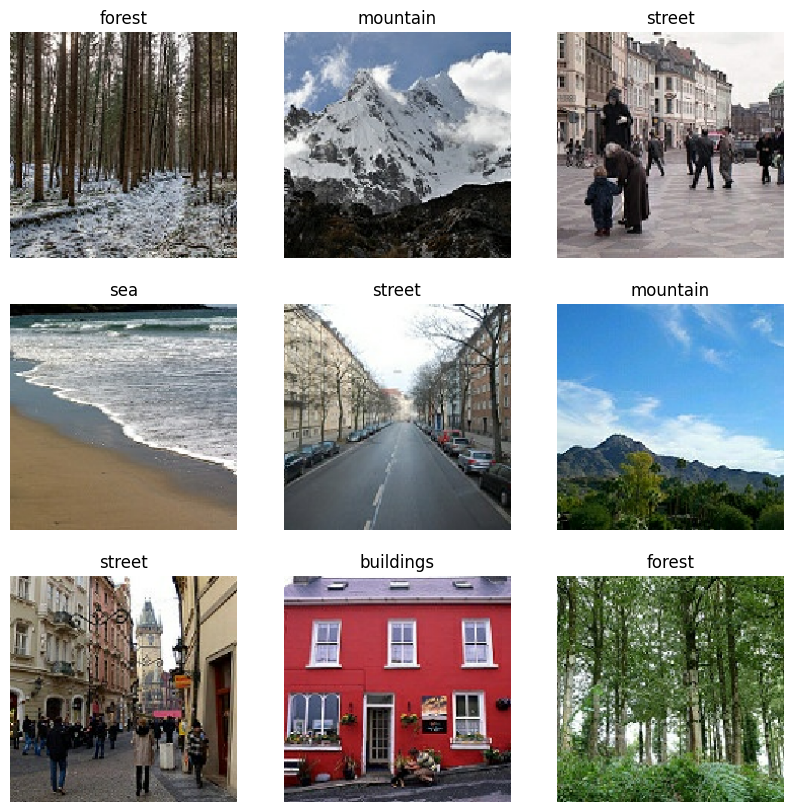

In [ ]:
import matplotlib.pyplot as plt

# Display a few sample images from the loaded dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds_full.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds_full.class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:
import math

# Define the base directory for training images
base_train_dir = os.path.join(extraction_path, 'seg_train', 'seg_train')

# Define validation split ratio
validation_split_ratio = 0.2

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_train_dir,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=validation_split_ratio,
    subset='training'
)

# Create initial validation dataset
val_ds_initial = tf.keras.utils.image_dataset_from_directory(
    base_train_dir,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=validation_split_ratio,
    subset='validation'
)


val_batches = tf.data.experimental.cardinality(val_ds_initial).numpy()

# Determine the number of batches for the final validation set (e.g., half of initial validation)
val_set_size = math.floor(val_batches * 0.5) # Let's use roughly 50% of the split-off validation for actual validation, the rest for test

# Split the initial validation set into validation and test sets
val_ds = val_ds_initial.take(val_set_size)
test_ds = val_ds_initial.skip(val_set_size)


print(f"Total training images: {tf.data.experimental.cardinality(train_ds).numpy() * batch_size}")
print(f"Total validation images: {tf.data.experimental.cardinality(val_ds).numpy() * batch_size}")
print(f"Total test images: {tf.data.experimental.cardinality(test_ds).numpy() * batch_size}")


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Total training images: 11232
Total validation images: 1408
Total test images: 1408


In [ ]:
import tensorflow as tf

# 1. Create a tf.keras.Sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

print("Data augmentation model created with RandomFlip, RandomRotation, and RandomZoom layers.")

Data augmentation model created with RandomFlip, RandomRotation, and RandomZoom layers.


In [ ]:
import tensorflow as tf

# 2. Create a preprocessing layer using tf.keras.layers.Rescaling
preprocess_input = tf.keras.layers.Rescaling(1./255)

print("Preprocessing layer created to normalize pixel values to [0, 1].")

Preprocessing layer created to normalize pixel values to [0, 1].


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Function to apply data augmentation and preprocessing to training data
def augment_and_preprocess(image, label):
    image = data_augmentation(image)
    image = preprocess_input(image)
    return image, label

# Function to apply only preprocessing to validation and test data
def preprocess_only(image, label):
    image = preprocess_input(image)
    return image, label

# Apply augmentation and preprocessing to the training dataset
train_ds = train_ds.map(augment_and_preprocess, num_parallel_calls=AUTOTUNE)

# Apply preprocessing to the validation and test datasets
val_ds = val_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)

# Configure datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Data augmentation and preprocessing applied to datasets.")
print("Training dataset configured for performance with caching, shuffling, and prefetching.")
print("Validation and Test datasets configured for performance with caching and prefetching.")

Data augmentation and preprocessing applied to datasets.
Training dataset configured for performance with caching, shuffling, and prefetching.
Validation and Test datasets configured for performance with caching and prefetching.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Get the number of classes from the training dataset
num_classes = len(train_ds_full.class_names) # Using train_ds_full which was successfully loaded

# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # Output layer with num_classes units and softmax activation
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Display the model summary
model.summary()

print("CNN model designed and compiled successfully.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,248,134 (84.87 MB)

 Trainable params: 22,247,174 (84.87 MB)

 Non-trainable params: 960 (3.75 KB)

CNN model designed and compiled successfully.


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.4261 - loss: 1.7193 - val_accuracy: 0.3786 - val_loss: 2.0846
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.5782 - loss: 1.1147 - val_accuracy: 0.4787 - val_loss: 1.3376
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.6284 - loss: 0.9792 - val_accuracy: 0.5774 - val_loss: 1.0673
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.6643 - loss: 0.8814 - val_accuracy: 0.5028 - val_loss: 1.5335
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.7242 - loss: 0.7676 - val_accuracy: 0.3956 - val_loss: 1.8834
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.7313 - loss: 0.7183 - val_accuracy: 0.6364 - val_loss: 1.0520
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.8243 - loss: 0.5080 - val_accuracy: 0.6293 - val_loss: 1.1049
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.8706 - loss: 0.3647 -

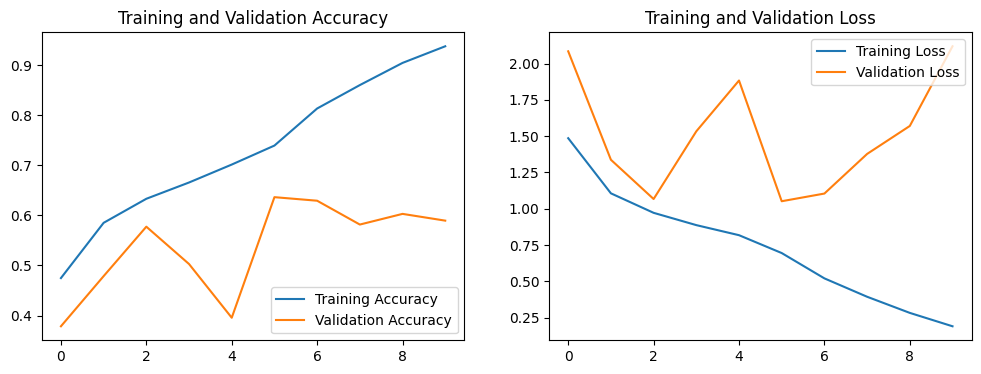

Training history visualization complete.


In [ ]:
import matplotlib.pyplot as plt

# Define the number of epochs for training
epochs = 10

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

print("Model training complete.")

# Visualize training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("Training history visualization complete.")

In [ ]:
import tensorflow as tf
import os
import math

# Re-define necessary variables from earlier successful steps
image_size = (224, 224)
batch_size = 32
extraction_path = '/content/dataset'

# Re-define data augmentation and preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])
preprocess_input = tf.keras.layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE

# Define the base directory for training images
base_train_dir = os.path.join(extraction_path, 'seg_train', 'seg_train')

# Define validation split ratio
validation_split_ratio = 0.2

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_train_dir,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=validation_split_ratio,
    subset='training'
)

# Create initial validation dataset
val_ds_initial = tf.keras.utils.image_dataset_from_directory(
    base_train_dir,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=validation_split_ratio,
    subset='validation'
)

# Determine the number of validation and test images
val_batches = tf.data.experimental.cardinality(val_ds_initial).numpy()
val_set_size = math.floor(val_batches * 0.5)

# Split the initial validation set into validation and test sets
val_ds = val_ds_initial.take(val_set_size)
test_ds = val_ds_initial.skip(val_set_size)

# Function to apply data augmentation and preprocessing to training data
def augment_and_preprocess(image, label):
    image = data_augmentation(image)
    image = preprocess_input(image)
    return image, label

# Function to apply only preprocessing to validation and test data
def preprocess_only(image, label):
    image = preprocess_input(image)
    return image, label

# Apply augmentation and preprocessing to the training dataset
train_ds = train_ds.map(augment_and_preprocess, num_parallel_calls=AUTOTUNE)

# Apply preprocessing to the validation and test datasets
val_ds = val_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)

# Configure datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Training, validation, and test datasets have been successfully re-created and preprocessed.")
print(f"Total training images: {tf.data.experimental.cardinality(train_ds).numpy() * batch_size}")
print(f"Total validation images: {tf.data.experimental.cardinality(val_ds).numpy() * batch_size}")
print(f"Total test images: {tf.data.experimental.cardinality(test_ds).numpy() * batch_size}")

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Training, validation, and test datasets have been successfully re-created and preprocessed.
Total training images: 11232
Total validation images: 1408
Total test images: 1408


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.5886 - loss: 1.9923
Test Loss: 2.1287
Test Accuracy: 0.5801


In [ ]:
import numpy as np

# Obtain model predictions for the entire test_ds dataset
predictions = model.predict(test_ds)

# Extract all true labels and corresponding images from the test_ds
# We need to unbatch the dataset to get individual images and labels
true_labels = []
images_for_plotting = []
for images, labels in test_ds.unbatch():
    true_labels.append(labels.numpy())
    images_for_plotting.append(images.numpy())

true_labels = np.array(true_labels)
images_for_plotting = np.array(images_for_plotting)

# Determine the predicted class for each image by finding the index of the maximum probability
predicted_classes = np.argmax(predictions, axis=1)

# Compare the predicted classes with the true labels to identify the indices of misclassified images
misclassified_indices = np.where(predicted_classes != true_labels)[0]

print(f"Total images in test_ds: {len(true_labels)}")
print(f"Total misclassified images: {len(misclassified_indices)}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
Total images in test_ds: 1398
Total misclassified images: 587


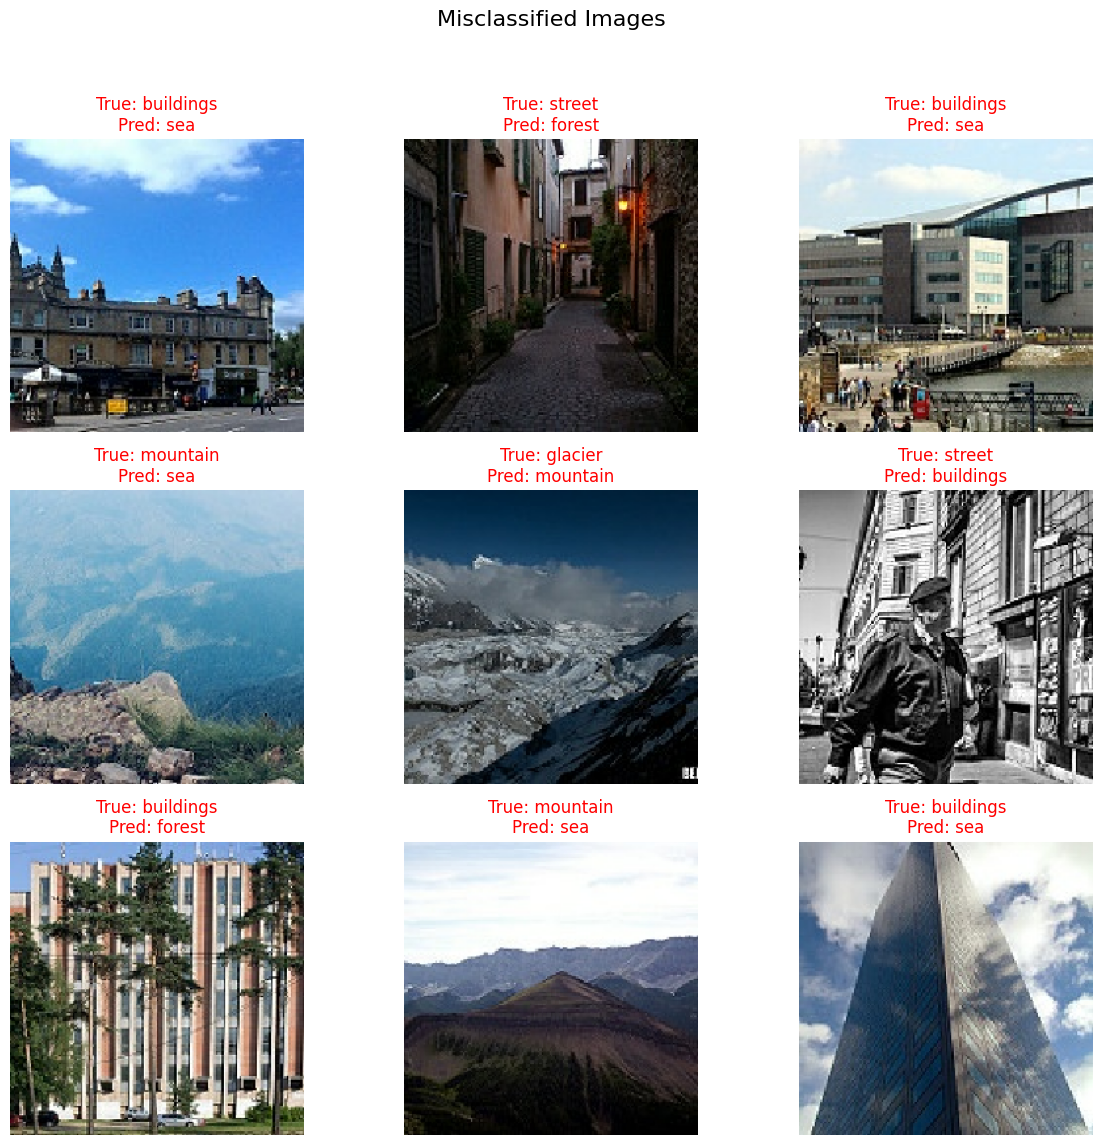

Displaying 9 misclassified images.


In [ ]:
import matplotlib.pyplot as plt

# Select a small number of misclassified images to visualize (e.g., up to 9)
num_misclassified_to_show = min(9, len(misclassified_indices))

plt.figure(figsize=(12, 12))
plt.suptitle('Misclassified Images', fontsize=16)

class_names = train_ds_full.class_names

for i, idx in enumerate(misclassified_indices[:num_misclassified_to_show]):
    ax = plt.subplot(3, 3, i + 1)

    plt.imshow(images_for_plotting[idx])

    # Set title with true and predicted labels
    true_label_name = class_names[true_labels[idx]]
    predicted_label_name = class_names[predicted_classes[idx]]
    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", color='red')
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

print(f"Displaying {num_misclassified_to_show} misclassified images.")